# Assignment 2
## Stochastic and Spatial Models
---
Peterson, Victoria J  
*ID: 15476758* 

Beumer, Wessel T L
*ID: 12640662*

University of Amsterdam  
*Introduction to Computational Science, Block 1, 2024*  

Due: 27 October 2024

---

In [139]:
import numpy as np
from scipy.integrate import odeint 
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import find_peaks
import networkx as nx
# import ndlib.models.epidemics as ep
import dataclasses
import matplotlib.pyplot as plt

from alive_progress import alive_bar
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("alive_progress")

In [3]:
@dataclasses.dataclass
class Results:
    S_List: list[int]
    I_List: list[int]
    R_List: list[int]
    time: list[float]

In [4]:
class Event:
    dX = 0.0
    dY = 0.0
    dZ = 0.0
    rate = 0.0


class Transmission(Event):
    def __init__(self, beta, X, Y, Z, N):
        self.dX = -1
        self.dY = 1
        self.dZ = 0
        self.rate = beta*X*Y/N

class Births(Event):
    def __init__(self, mu, X, Y, Z, N):
        self.dX = 1
        self.dY = 0
        self.dZ = 0
        self.rate = mu*N

class DeathsX(Event):
    def __init__(self, mu, X, Y, Z, N):
        self.dX = -1
        self.dY = 0.0
        self.dZ = 0.0
        self.rate = mu*X

class DeathsY(Event):
    def __init__(self, mu, X, Y, Z, N):
        self.dX = 0.0
        self.dY = -1
        self.dZ = 0.0
        self.rate = mu*Y

class DeathsZ(Event):
    def __init__(self, mu, X, Y, Z, N):
        self.dX = 0.0
        self.dY = 0.0
        self.dZ = -1
        self.rate = mu*Z

class Recovery(Event):
    def __init__(self, gamma, X, Y, Z, N):
        self.dX = 0.0
        self.dY = -1
        self.dZ = 1
        self.rate = gamma*Y

In [5]:
class SIRModelGillespies:
    def __init__ (self, X, Y, Z, N, beta, gamma, mu):
        
        self.X = X
        self.Y = Y
        self.Z = Z
        self.N = N
        self.beta = beta
        self.gamma = gamma
        self.mu = mu
        self.results = Results([], [], [], [])

    def calcEvents(self):
        events = []
        events.append(Transmission(self.beta, self.X, self.Y, self.Z, self.N))
        events.append(Births(self.mu, self.X, self.Y, self.Z, self.N))
        events.append(DeathsX(self.mu, self.X, self.Y, self.Z, self.N))
        events.append(DeathsY(self.mu, self.X, self.Y, self.Z, self.N))
        events.append(DeathsZ(self.mu, self.X, self.Y, self.Z, self.N))
        events.append(Recovery(self.gamma, self.X, self.Y, self.Z, self.N))
        return events

    def gillespiesAlgorithm(self):
        events = self.calcEvents()
        rateTotal = sum([i.rate for i in events])

        deltaT = -1/rateTotal * np.log(np.random.rand())

        probabilities = np.random.rand() * rateTotal

        upperRate = 0

        for i in events:
            lowerRate = upperRate
            upperRate += i.rate

            if lowerRate < probabilities <= upperRate:
                return i, deltaT


    def gillespiesSimulation(self, finalTime):
        time = 0

        while time < finalTime:
            event, deltaT = self.gillespiesAlgorithm()
            time += deltaT

            self.X += event.dX
            self.Y += event.dY
            self.Z += event.dZ

            self.results.S_List.append(self.X)
            self.results.I_List.append(self.Y)
            self.results.R_List.append(self.Z)
            self.results.time.append(time)


In [6]:
class SIRModelDeterministic:
    def __init__ (self, X, Y, Z, N, beta, gamma, mu, timeInterval, timeFinal):
        
        self.X = X
        self.Y = Y
        self.Z = Z
        self.N = N
        self.beta = beta
        self.gamma = gamma
        self.mu = mu
        self.timeInterval = timeInterval
        self.timeFinal = timeFinal
        self.results = Results([], [], [], [])

    def SIRModel(self):
        timeSpan = np.arange(0, self.timeFinal, step = self.timeInterval)

        S = np.zeros(round(self.timeFinal/self.timeInterval))
        I = np.zeros(round(self.timeFinal/self.timeInterval))
        R = np.zeros(round(self.timeFinal/self.timeInterval))

        S[0], I[0], R[0] = self.X, self.Y, self.Z

        for t in range(1, len(timeSpan)):
            dSdt = self.mu * (self.N - S[t-1]) - self.beta * S[t-1] * I[t-1] / self.N
            dIdt = self.beta * S[t-1] * I[t-1] / self.N - self.gamma * I[t-1] - self.mu * I[t-1]
            dRdt = self.gamma * I[t-1] - self.mu * R[t-1]

            S[t] = S[t-1] + self.timeInterval * dSdt
            I[t] = I[t-1] + self.timeInterval * dIdt
            R[t] = R[t-1] + self.timeInterval * dRdt

        self.results.S_List = S
        self.results.I_List = I
        self.results.R_List = R
        self.results.time = timeSpan

            


In [7]:
def fourierOnSeries(series, averageTimeStepSize, height = 1e5, width = 2):
    I_array = np.array(series)
    I_array -= I_array.mean()

    fourier_analysis = np.array(fft(I_array))
    freqs = fftfreq(len(I_array), d=averageTimeStepSize)
    fourier_analysis = np.abs(np.real(fourier_analysis))

    peaks, peak_properties = find_peaks(fourier_analysis, height=height, width=width )

    plt.plot(freqs, fourier_analysis, "g.", label="Fourier Transformation")
    for peak in peaks:
        if freqs[peak] >= 0:
            plt.plot(freqs[peak], fourier_analysis[peak], "ro", label=f"Peak {round(freqs[peak], 6)}") #type: ignore
    plt.xlim(0, 0.1)
    plt.title("Fourier analysis of Infected fraction")
    plt.xlabel("Frequency")
    plt.ylabel("Intensity")
    plt.legend()
    plt.show()

In [147]:
# Initial Values
X0 = 999
Y0 = 1
Z0 = 0
N = X0 + Y0 + Z0
beta = 0.5
gamma = 0.1
mu = 0.005

maxTime = 1000


model = SIRModelGillespies(X0, Y0, Z0, N, beta, gamma, mu)

model.gillespiesSimulation(maxTime)

#for i in range(len(model.results.time)):
#    print(model.results.time[i], model.results.S_List[i], model.results.I_List[i], model.results.R_List[i])


deterministicModel = SIRModelDeterministic(X0, Y0, Z0, N, beta, gamma, mu, 1, maxTime)

deterministicModel.SIRModel()

# for i in range(len(deterministicModel.results.time)):
#     print(deterministicModel.results.time[i], deterministicModel.results.S_List[i], deterministicModel.results.I_List[i], deterministicModel.results.R_List[i])

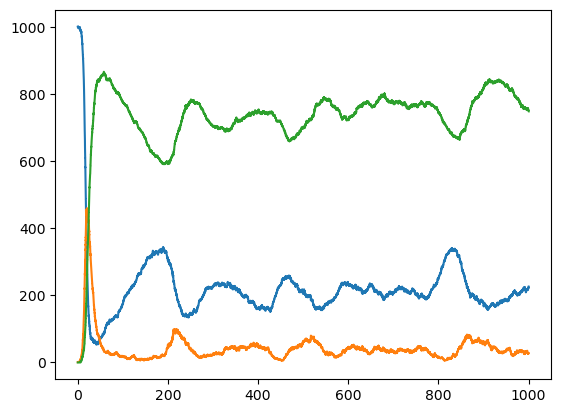

In [8]:
plt.figure()
plt.plot(model.results.time, model.results.S_List, label='S')
plt.plot(model.results.time, model.results.I_List, label='I')
plt.plot(model.results.time, model.results.R_List, label='R')

plt.show()

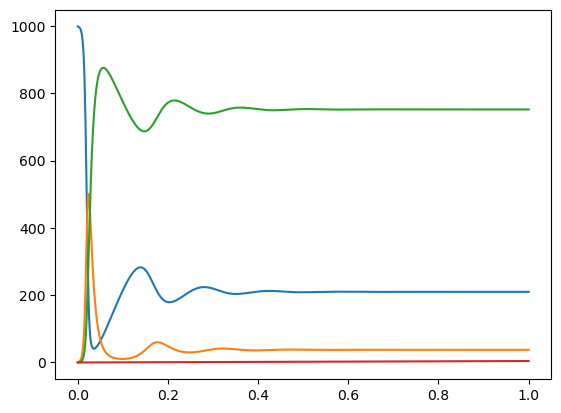

In [150]:
plt.figure()
plt.plot(deterministicModel.results.time, deterministicModel.results.S_List, label='S')
plt.plot(deterministicModel.results.time, deterministicModel.results.I_List, label='I')
plt.plot(deterministicModel.results.time, deterministicModel.results.R_List, label='R')
plt.plot(deterministicModel.results.time, sinewave(deterministicModel.results.time))
plt.show()

# Fourier analysis of stochastic model

len(model.results.time) = 515085


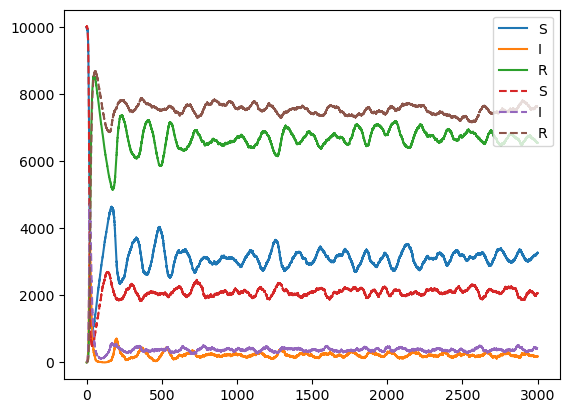

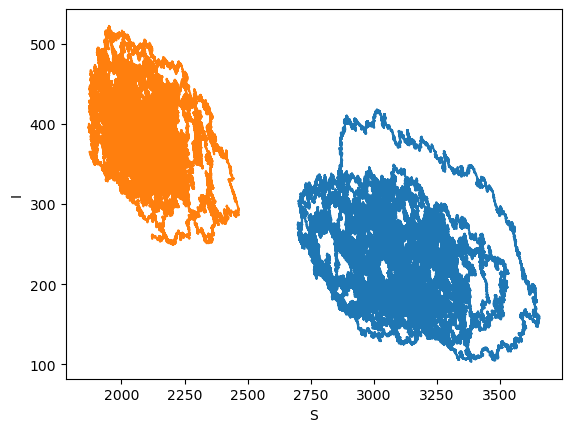

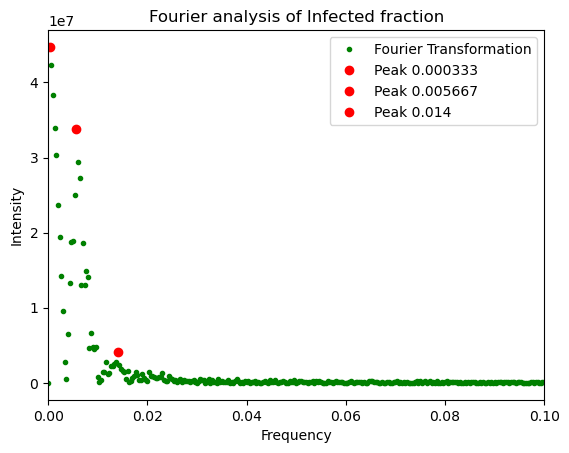

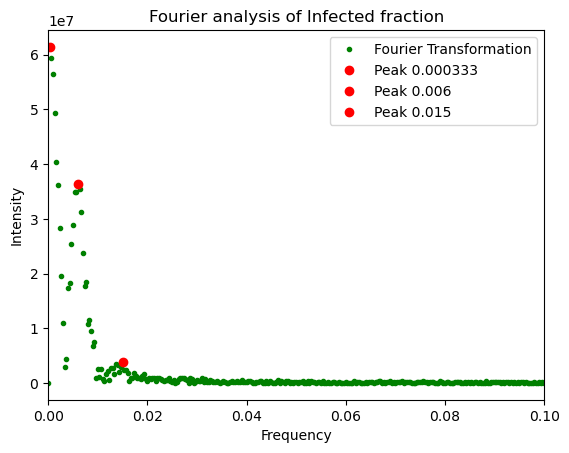

len(model.results.I_List) = 515085
len(model2.results.I_List) = 544630


In [142]:
# Initial Values
X0 = 9995 
Y0 = 5
# X0 = 1000
# Y0 = 0
Z0 = 0
N = X0 + Y0 + Z0
beta = 0.5
gamma = 0.15
mu = 0.005
maxTime = 3000

model = SIRModelGillespies(X0, Y0, Z0, N, beta, gamma, mu)
model2 = SIRModelGillespies(X0, Y0, Z0, N, beta, 0.1, mu)
model.gillespiesSimulation(maxTime)
model2.gillespiesSimulation(maxTime)

print(f"{len(model.results.time) = }")
plt.plot(model.results.time, model.results.S_List, "-", label='S')
plt.plot(model.results.time, model.results.I_List, "-", label='I')
plt.plot(model.results.time, model.results.R_List, "-", label='R')
plt.plot(model2.results.time, model2.results.S_List, "--", label='S')
plt.plot(model2.results.time, model2.results.I_List, "--", label='I')
plt.plot(model2.results.time, model2.results.R_List, "--", label='R')
plt.legend(loc="upper right")
plt.show()

averageTimeStepSize = np.diff(np.array(model.results.time)).mean()
averageTimeStepSize2 = np.diff(np.array(model2.results.time)).mean()
t500 = round(800/averageTimeStepSize)
plt.plot(model.results.S_List[t500:], model.results.I_List[t500:])
plt.plot(model2.results.S_List[t500:], model2.results.I_List[t500:])
plt.xlabel("S")
plt.ylabel("I")
plt.show()


fourierOnSeries(model.results.I_List, averageTimeStepSize, height=1e6, width=3)
fourierOnSeries(model2.results.I_List, averageTimeStepSize2, height=1e6, width=3)
print(f"{len(model.results.I_List) = }")
print(f"{len(model2.results.I_List) = }")

|████████████████████████████████████████| 60/60 [100%] in 7:52.3 (0.13/s)      


[]

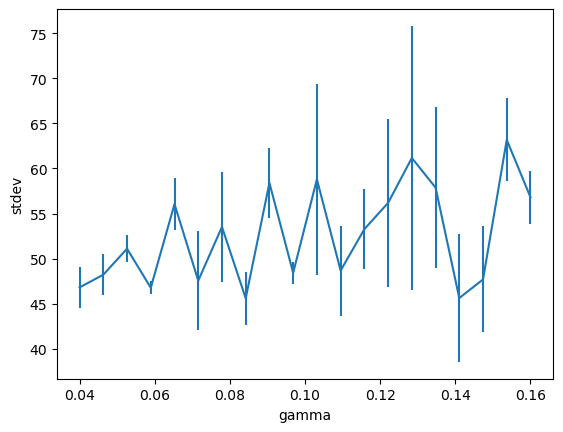

In [143]:
# Initial Values
X0 = 9995 
Y0 = 5
# X0 = 1000
# Y0 = 0
Z0 = 0
N = X0 + Y0 + Z0
beta = 0.3
# gamma = 0.1
mu = 0.005
maxTime = 1000

stdev_list = []
stdev_std = []
gamma_space = np.linspace(0.04, 0.16, 40)

with alive_bar(3*len(gamma_space), force_tty=True) as bar:
    for gamma in gamma_space:
        samples = 5
        stdev = np.zeros(samples)
        while samples > 0:
            model = SIRModelGillespies(X0, Y0, Z0, N, beta, gamma, mu)
            model.gillespiesSimulation(maxTime)
            if model.results.I_List[-1] == 0:
                continue
            averageTimeStepSize = np.diff(np.array(model.results.time)).mean()
            measureStartTime = round(500/averageTimeStepSize)
            stdev[samples - 1] = np.std(np.array(model.results.I_List)[measureStartTime:])
            samples -= 1
            bar()
        stdev_std.append(np.std(stdev))
        stdev_list.append((stdev[0] + stdev[1] + stdev[2])/3)

plt.errorbar(gamma_space, stdev_list, yerr=stdev_std, fmt="o")
plt.xlabel("gamma")
plt.ylabel("stdev")
plt.plot()
    # averageTimeStepSize = np.diff(np.array(model.results.time)).mean()
    # fourierOnSeries(model.results.I_List, averageTimeStepSize, height=1e6, width=1)

[]

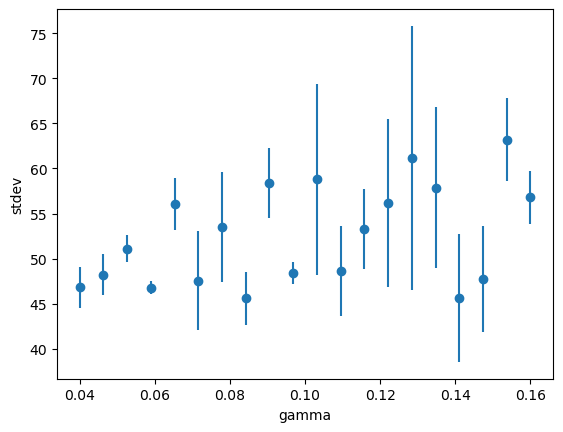

In [144]:
plt.errorbar(gamma_space, stdev_list, yerr=stdev_std, fmt="o")
plt.xlabel("gamma")
plt.ylabel("stdev")
plt.plot()

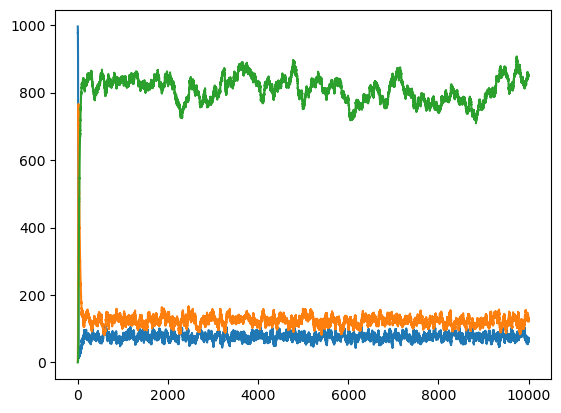

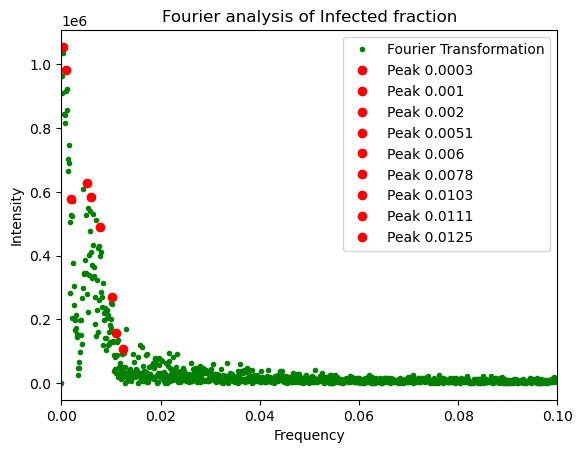

In [170]:
# Initial Values
X0 = 995  
Y0 = 5
Z0 = 0
N = X0 + Y0 + Z0
beta = 0.5
gamma = 0.033
mu = 0.005
maxTime = 10000

model = SIRModelGillespies(X0, Y0, Z0, N, beta, gamma, mu)
model.gillespiesSimulation(maxTime)

plt.plot(model.results.time, model.results.S_List, label='S')
plt.plot(model.results.time, model.results.I_List, label='I')
plt.plot(model.results.time, model.results.R_List, label='R')
plt.show()
averageTimeStepSize = np.diff(np.array(model.results.time)).mean()

fourierOnSeries(model.results.I_List, averageTimeStepSize)

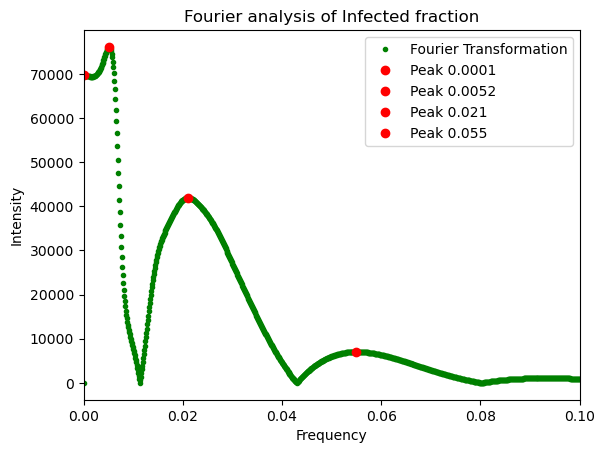

In [165]:
deterministicModel = SIRModelDeterministic(995, 5, 0, 1000, 0.5, 0.1, 0.005, 0.1, 10000)
deterministicModel.SIRModel()
fourierOnSeries(deterministicModel.results.I_List, deterministicModel.timeInterval, height=3000)

In [115]:
periodic = np.sin(2*np.pi*np.linspace(0, 1000, 10000))
print(f"{periodic = }")
print(f"{np.std(periodic) = }")
random = np.random.random(10000) * 2 - 1
print(f"{random = }")
print(f"{np.std(random) = }")

periodic = array([ 0.00000000e+00,  5.87836088e-01,  9.51095345e-01, ...,
       -9.51095345e-01, -5.87836088e-01, -6.42833292e-13])
np.std(periodic) = 0.7070714249635606
random = array([-0.29153615,  0.4135036 ,  0.30191478, ..., -0.23649256,
        0.40512191,  0.2131375 ])
np.std(random) = 0.5757053587523004
